### 1. Visualise nonce predictions over the course of training

In [2]:
from collections import defaultdict
import unidecode
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_context("talk")


def sum_lists(lists):
    lists = np.matrix(lists).sum(axis=0).tolist()
    return lists[0]

def strip(word):
    return "".join(word.split()[1:])

import unidecode


def categorise(source, target):
    """
    Return a numerical label indicating inflection class.

    Args:
        source (str): source with gender as first character ("<f> k a t z e ")
        target (str): (predicted) target

    Returns:
        int indicating class, ranges from 0 - 6
    """
    assert "<" in source.split()[0], "Your source sequence has no gender tag!"

    source = source.replace(" </s>", "")
    target = target.replace(" </s>", "")
    source = unidecode.unidecode(source).split()[1:]
    target = unidecode.unidecode(target).split()

    # zero or epsilon
    if target == source:
        category = 2
    elif len(target) > len(source) and target[:len(source)] == source:
        # (e)n
        if target[-1:] == ["n"]:
            category = 0
        # e
        elif target[-1:] == ["e"]:
            category = 1
        # e r
        elif target[-2:] == ["e", "r"]:
            category = 3
        # s
        elif target[-1:] == ["s"]:
            category = 4
        # repeated input but odd suffix
        elif target[:len(source)] == source:
            category = 5
    else:
        # didn't even repeat the input
        category = 6
    return category

In [3]:
def plot(tag, top):
    words = []
    predicted_classes_rhyme = defaultdict(lambda: defaultdict(list))
    predicted_classes_non_rhyme = defaultdict(lambda: defaultdict(list))

    seeds = [1, 2, 3, 4, 5]

    # Collect the predicted categories from 25 epochs and 5 seeds
    for epoch in range(1, 25):
        for seed in seeds:
            with open(f"../opennmt/models/seed={seed}_wiktionary/nonce/lstms2s_nonce_{tag}_{epoch}.prd", encoding="utf-8") as f_prd, \
                 open(f"../wiktionary/nonce/nonce_{tag}.src", encoding="utf-8") as f_src:
                all_prds = f_prd.readlines()
                src = f_src.readlines()
                for i, (source, j) in enumerate(zip(src, range(0, len(all_prds), 5))):
                    word = strip(source)
                    words.append(word)
                    prds = all_prds[j:j + 5][:top]
                    for p in prds:
                        category = categorise(source.strip(), p.strip())
                        if i < 12:
                            predicted_classes_rhyme[epoch][word].append(category)
                        else:
                            predicted_classes_non_rhyme[epoch][word].append(category)

    words = set(words) 
    length = 12 * top * len(seeds)

    final_epochs = dict()
    for setup, data in [("rhyme", predicted_classes_rhyme),
                        ("non_rhyme", predicted_classes_non_rhyme)]:
        colours = sns.color_palette("Spectral", 5)
        colours[2] = "purple"
        epochs = list(range(1, 25))
        # Count the frequency of each class per epoch
        class_0 = [sum([data[i][w].count(0) for w in words]) / length * 100 for i in range(1, 25)]
        class_1 = [sum([data[i][w].count(1) for w in words]) / length * 100 for i in range(1, 25)]
        class_2 = [sum([data[i][w].count(2) for w in words]) / length * 100 for i in range(1, 25)]
        class_3 = [sum([data[i][w].count(3) for w in words]) / length * 100 for i in range(1, 25)]
        class_4 = [sum([data[i][w].count(4) for w in words]) / length * 100 for i in range(1, 25)]
        class_5 = [sum([data[i][w].count(6) + data[i][w].count(5) for w in words]) / length * 100 for i in range(1, 25)]
        final_epochs[setup] = [class_0[-1], class_1[-1], class_2[-1],
                               class_3[-1], class_4[-1], class_5[-1]]

        # Plot cumulative distributions of the inflection classes
        plt.figure(figsize=(4, 4))
        sns.lineplot(x=epochs, y=class_0, color=colours[0], label="-n")
        plt.fill_between(epochs, [0 for _ in epochs], class_0, color=colours[0], alpha=0.25)
        sns.lineplot(x=epochs, y=sum_lists([class_0, class_1]), color=colours[1], label="-e")
        plt.fill_between(epochs, class_0,
                         sum_lists([class_0, class_1]), color=colours[1], alpha=0.25)
        sns.lineplot(x=epochs, y=sum_lists([class_0, class_1, class_2]), color=colours[2], label=r"-$\o$",
                     zorder=-1)
        plt.fill_between(epochs, sum_lists([class_0, class_1]),
                         sum_lists([class_0, class_1, class_2]), color=colours[2], alpha=0.25)
        sns.lineplot(x=epochs, y=sum_lists([class_0, class_1, class_2, class_3]), color=colours[3], label="-er")
        plt.fill_between(epochs, sum_lists([class_0, class_1, class_2]),
                         sum_lists([class_0, class_1, class_2, class_3]), color=colours[3], alpha=0.25)
        sns.lineplot(x=epochs, y=sum_lists([class_0, class_1, class_2, class_3, class_4]), color=colours[4],
                     label="-s")
        plt.fill_between(epochs, sum_lists([class_0, class_1, class_2, class_3]),
                         sum_lists([class_0, class_1, class_2, class_3, class_4]), color=colours[4], alpha=0.25)
        # The remainder should be grey
        plt.fill_between(epochs, sum_lists([class_0, class_1, class_2, class_3, class_4]),
                         [100 for _ in epochs], color="grey", alpha=0.25, label="-?")

        # Label axes and only create a legend in one setup
        plt.xlabel("epochs")
        plt.ylabel("% of nonce predictions")
        plt.ylim(0, 100)
        plt.xlim(1, 24)
        #plt.title(f"{setup} - {TAG} - top {TOP}")

        if setup == "non_rhyme" and top == 1 and tag == "n":
            plt.legend(bbox_to_anchor=(1, 1.05), frameon=False)
        else:
            plt.legend([], [], frameon=False)
        plt.savefig(f"figures/nonce_setup={setup}_top={top}_tag={tag}.pdf", bbox_inches="tight")
        
    return predicted_classes_rhyme, predicted_classes_non_rhyme, final_epochs

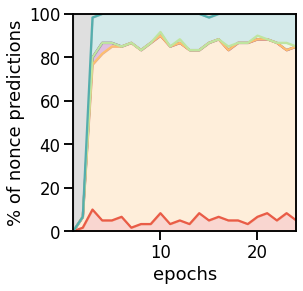

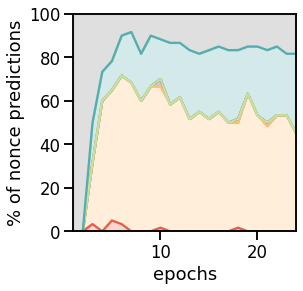

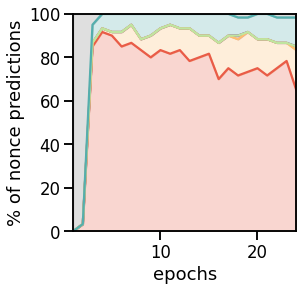

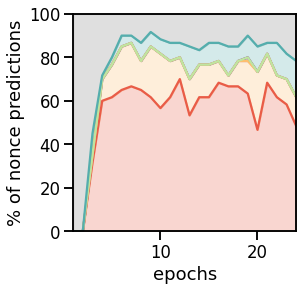

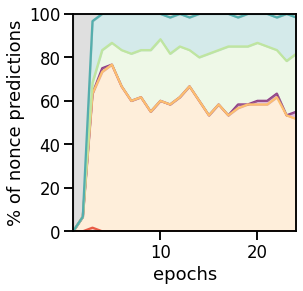

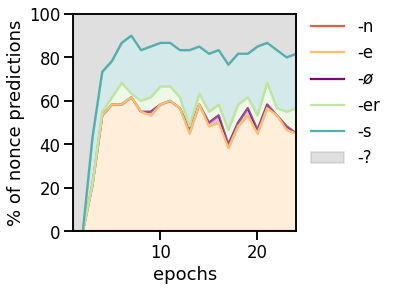

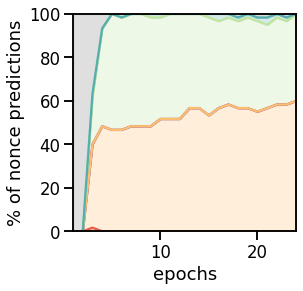

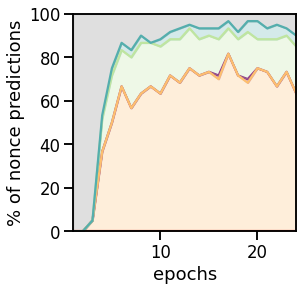

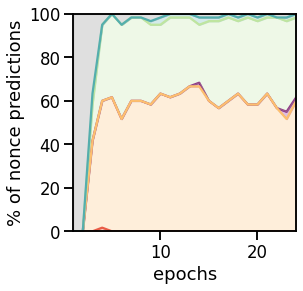

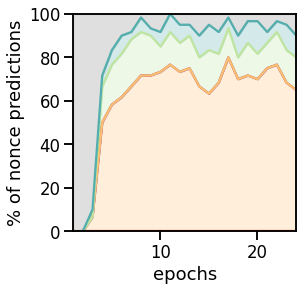

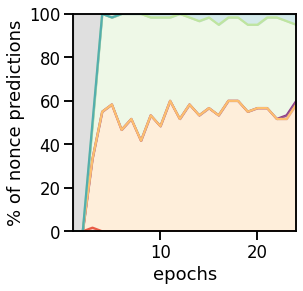

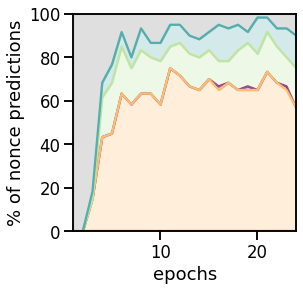

In [4]:
predicted_classes_rhyme, predicted_classes_non_rhyme, final_epochs_m = plot("m", 1)
predicted_classes_rhyme, predicted_classes_non_rhyme, final_epochs_f = plot("f", 1)
predicted_classes_rhyme, predicted_classes_non_rhyme, final_epochs_n = plot("n", 1)
predicted_classes_rhyme, predicted_classes_non_rhyme, final_epochs_zahn = plot("compound_zahn", 1)
predicted_classes_rhyme, predicted_classes_non_rhyme, final_epochs_tier = plot("compound_tier", 1)
predicted_classes_rhyme, predicted_classes_non_rhyme, final_epochs_hand = plot("compound_hand", 1)

### 2. Plot nonce predictions for all gender tags and compounds, for last epoch

In [5]:
final_epochs_n

{'rhyme': [0.0,
  51.66666666666667,
  3.3333333333333335,
  26.666666666666668,
  16.666666666666664,
  1.6666666666666667],
 'non_rhyme': [0.0, 45.0, 0.0, 11.666666666666666, 25.0, 18.333333333333332]}

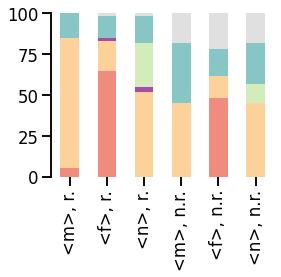

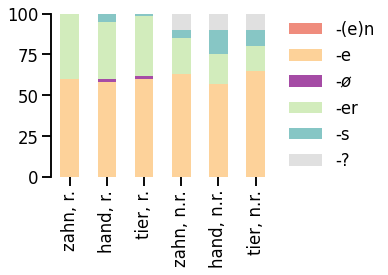

In [6]:
import pandas as pd
from matplotlib.colors import ListedColormap

a = pd.DataFrame({"<m>, r.": final_epochs_m["rhyme"],
                  "<f>, r.": final_epochs_f["rhyme"],
                  "<n>, r.": final_epochs_n["rhyme"],
                  "<m>, n.r.": final_epochs_m["non_rhyme"],
                  "<f>, n.r.": final_epochs_f["non_rhyme"],
                  "<n>, n.r.": final_epochs_n["non_rhyme"]})
colours = sns.color_palette("Spectral", 5) + ["lightgrey"]
colours[2] = "purple"
ax = a.T.plot(kind="bar", stacked=True, colormap=ListedColormap(colours), alpha=0.7, orientation="vertical",
              figsize=(4, 3))
ax.set_ylim(0, 100)
ax.set_xticklabels(a.keys())
plt.legend([], [], frameon=False)
sns.despine(bottom=True, right=True, top=True)
plt.savefig("figures/nonce_predictions_all_genders.pdf", bbox_inches="tight")

a = pd.DataFrame({"zahn, r.": final_epochs_zahn["rhyme"],
                  "hand, r.": final_epochs_hand["rhyme"],
                  "tier, r.": final_epochs_tier["rhyme"],
                  "zahn, n.r.": final_epochs_zahn["non_rhyme"],
                  "hand, n.r.": final_epochs_hand["non_rhyme"],
                  "tier, n.r.": final_epochs_tier["non_rhyme"]})
colours = sns.color_palette("Spectral", 5) + ["lightgrey"]
colours[2] = "purple"
ax = a.T.plot(kind="bar", stacked=True, colormap=ListedColormap(colours), alpha=0.7, orientation="vertical",
              figsize=(4, 3))
ax.set_ylim(0, 100)
ax.set_xticklabels(a.keys())
plt.legend(frameon=False, bbox_to_anchor=(1, 1.05), labels=["-(e)n", "-e", r"-$\o$", "-er", "-s", "-?"])
sns.despine(bottom=True, right=True, top=True)
plt.savefig("figures/nonce_predictions_compounds.pdf", bbox_inches="tight")